In [33]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not(PATH/FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH/FILENAME).open("wb").write(content)

In [17]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


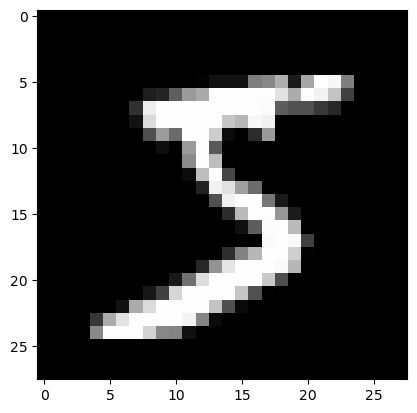

In [18]:
from  matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

# 注意数据需要转换成tensor才能参与后续建模训

In [20]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/var/folders/2g/d27fqh0s1x15sknzqypt6cd00000gn/T/ipykernel_35921/2266007477.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


#### torch.nn.functional很多层和函数在这里都会见到
- torch.nn.functional有很多功能，后续会常用的，那什么时候使用nn.Module,什么时候使用nn.functional？
- 一般情况下，如果模型有可学习的参数，最好用nn.Module,其他情况nn.functional相对更简单一些

In [21]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [22]:
bs = 64
xb = x_train[0:bs] # a mini-batch  from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float, requires_grad = True)
bs = 64
bias = torch.zeros(10, requires_grad=True)
print(loss_func(model(xb), yb))

tensor(12.7821, grad_fn=<NllLossBackward0>)


#### 创建一个model来更简化代码
- 必须继承nn.Module且在其构造函数中需要调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器


In [23]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


#### 可以打印我们定义好名字里的权重和偏置项

In [24]:
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0330, -0.0061, -0.0054,  ..., -0.0283,  0.0083,  0.0317],
        [-0.0235, -0.0201,  0.0347,  ..., -0.0145, -0.0090,  0.0117],
        [ 0.0036, -0.0049,  0.0265,  ..., -0.0201, -0.0179,  0.0170],
        ...,
        [-0.0088,  0.0287,  0.0113,  ..., -0.0189, -0.0282,  0.0046],
        [-0.0064,  0.0326,  0.0113,  ...,  0.0159, -0.0135, -0.0353],
        [ 0.0227, -0.0002,  0.0225,  ...,  0.0074, -0.0161, -0.0126]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-1.9396e-02,  8.4284e-03,  1.5730e-02, -2.1988e-02,  1.3432e-02,
        -6.2439e-03, -6.6784e-03,  1.9832e-02,  9.8350e-03,  3.2715e-02,
         6.2802e-03, -2.9357e-02,  2.1415e-03, -2.4042e-02, -1.3089e-02,
        -5.8933e-03, -1.6689e-02, -8.1898e-03,  8.9319e-03,  3.1116e-02,
        -2.4093e-05, -3.0979e-03, -2.6263e-02, -2.6842e-03,  8.3232e-03,
        -2.2129e-02,  1.7525e-02, -9.0573e-03,  1.6172e-02,  2.0581e-02,
      

#### 使用TensorDataSet和DataLoader来简化

In [27]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [28]:
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train(),这样会正常使用Batch Normalization和Dropout
- 测试的时候一般选择model.eval(),这样就不会使用Batch Normalization和Dropout

In [31]:
import numpy as np
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:' + str(step), '验证集损失:' + str(val_loss))

from  torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

#### 三行搞定

In [32]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt  = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失:2.27742477684021
当前step:1 验证集损失:2.24214747467041
当前step:2 验证集损失:2.1867171966552736
当前step:3 验证集损失:2.096063547515869
当前step:4 验证集损失:1.9503003734588622
当前step:5 验证集损失:1.7381544765472412
当前step:6 验证集损失:1.4856054355621338
当前step:7 验证集损失:1.2465494743347167
当前step:8 验证集损失:1.0541899835586548
当前step:9 验证集损失:0.9085170248031617
当前step:10 验证集损失:0.7995493671417236
当前step:11 验证集损失:0.7154311067581177
当前step:12 验证集损失:0.6507110740661621
当前step:13 验证集损失:0.5984433879852294
当前step:14 验证集损失:0.556724278640747
当前step:15 验证集损失:0.5235785067558288
当前step:16 验证集损失:0.4954576874732971
当前step:17 验证集损失:0.47268485436439517
当前step:18 验证集损失:0.4529767426967621
当前step:19 验证集损失:0.43633910393714903
当前step:20 验证集损失:0.42246720376014707
当前step:21 验证集损失:0.4098489918231964
当前step:22 验证集损失:0.3990304673910141
当前step:23 验证集损失:0.3893602008581161
当前step:24 验证集损失:0.3810117306232452
